Notebook to determine the noise level in AZKABAN during zooplankton experiment January 2022 in Ny-Ålesund

In [1]:
import csv
import os
import glob
from datetime import timedelta
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import matplotlib.dates as mdates
import warnings
%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

warnings.simplefilter("ignore")

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16



## Analysis
In Echoview, Single Echo Detection + 0.07m mask on TS data, only noise left.

Export TS (nominal frequency) of noise.

In [3]:
#Read file
flist = glob.glob('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise/noise*.0.csv')

In [4]:
nfiles = len(flist)

In [5]:
flist

['C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise185.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise186.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise187.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise188.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise189.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise190.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise191.0.csv',
 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise\\noise192.

In [6]:
# Determine basic parameters
noise = pd.read_csv(flist[0],header=None, skiprows=1,index_col = 0)


time_cols = [0,4,5]
times=[]
for ind in range(0,len(noise)):
            times = np.append(times, datetime.strptime('%s.%s' %(noise[4].values[ind],int(noise[5].values[ind])), '%H:%M:%S.%f'))


start = 15
n_bins = np.shape(noise)[1]-start

TS_cols = np.arange(start,n_bins+start)

depth = pd.read_csv(flist[0],header=None, skiprows=1, usecols=[8,9], nrows=1)
start_range = depth[8][0]
end_range = depth[9][0]
d_range = (end_range-start_range)/(n_bins-2)

N = 18 
depth_range = np.linspace(start_range, end_range,n_bins-1)
edge = int(N/2)
depth_smooth = depth_range[edge:-edge-1]

In [7]:
# read TS data at different f
smooth = np.empty((322,nfiles))
for i in range(nfiles):
    TS_data = pd.read_csv(flist[i],header=None, skiprows=1,index_col = 0, usecols=TS_cols)
    TS_data_thres = np.where(TS_data<-999,np.nan,TS_data) # Change -999 to NaN
    
    N = 18  #0.1m/d_range

    conv_TS = np.convolve(np.nanmedian(TS_data_thres,0), np.ones(N)/N, mode='full')
    smooth_TS = conv_TS[N:-N]

    smooth[:,i] = smooth_TS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


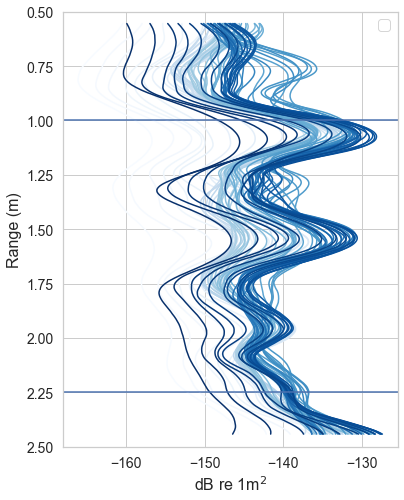

In [8]:
cmap = plt.cm.Blues(np.linspace(0,1,nfiles))
freq = np.linspace(185,255,71)

plt.figure(figsize=(6,8))
for i in range(nfiles):
    plt.plot(smooth[:,i], depth_smooth, color=cmap[i])
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()

Text(0, 0.5, 'TS (dB re 1m$^2$)')

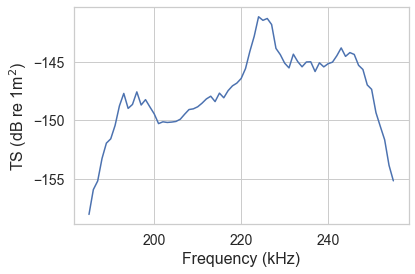

In [9]:
# Plot noise across the bandwidth at 1.50 m

d_ind = np.where(depth_range>=1.7)[0][0]

plt.plot(freq,smooth[d_ind,:])
plt.xlabel('Frequency (kHz)')
plt.ylabel('TS (dB re 1m$^2$)')

In [10]:
np.max(smooth)

-127.3437801111111

### Make datetime array

### plot noise profile with used range limits indicated

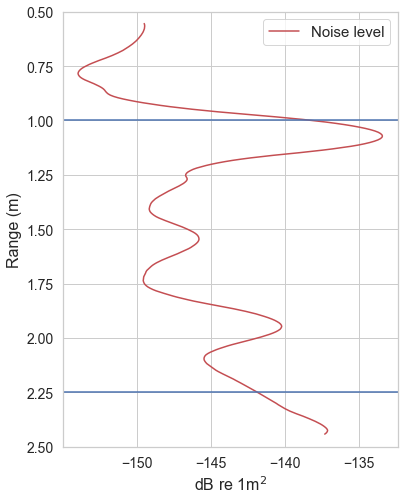

In [11]:
ind_200 = np.where(freq==200)[0][0]

plt.figure(figsize=(6,8))
plt.plot(smooth[:,ind_200], depth_smooth, 'r-', label='Noise level')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()

### Export to file 

In [12]:
#noise_df = pd.DataFrame({'range':depth_smooth,'TS':smooth})
#noise_df = noise_df.reset_index()

In [13]:
#noise_df.to_feather('Noise_AZKABAN_200kHz.feather')

# Read SED
Compare TS from SEDs with regular parameters to the noise level

In [14]:
def tsf_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        df['Ping_microseconds'] = df.Ping_milliseconds * 1000
        df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
        df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
        df.drop(columns=['Ping_date_Ping_time',
                         'Ping_milliseconds',
                         'Ping_microseconds'],
               inplace=True)
        
        return df
    
    transposed_path = file_path[:-4] + '_transposed.csv'
    if os.path.isfile(transposed_path) == True:
        df = pd.read_csv(transposed_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    else:
        df = pd.read_csv(file_path, low_memory=False).T
        file_path = transposed_path
        df.to_csv(path_or_buf=file_path)
        print('A transposed TS(f) file was created at: \n' + str(file_path))    
        df = pd.read_csv(file_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    
    df = get_datetime(df)
    
    return df


In [15]:
SED_df = tsf_import('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/SED_ZoopMix_newcal.csv')

TypeError: Dimensions of C (341, 659) are incompatible with X (659) and/or Y (342); see help(pcolormesh)

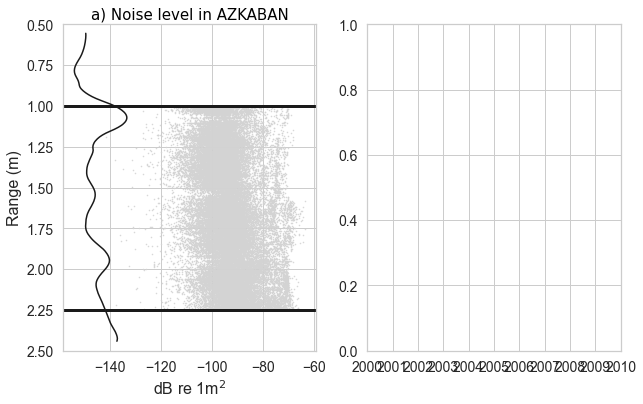

In [16]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(smooth[:,ind_200], depth_smooth, 'k-', label='Noise level')
plt.plot(SED_df['200.000'],SED_df['Range'], '.', color='lightgrey',markersize=1)
plt.axhline(y=1, c='k', linewidth=3)
plt.axhline(y=2.25, c='k', linewidth=3)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
#plt.legend(fontsize=15)
plt.title('a) Noise level in AZKABAN', title_font)
plt.gca().invert_yaxis()

ax = plt.subplot(1,2,2)
plt.pcolormesh(times,np.linspace(start_range, end_range,n_bins),TS_data_thres.T, cmap="Greys")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel('Time on 17.01.2022', axis_font)
plt.clim([-150,-80])
plt.gca().invert_yaxis()
plt.title('b) Signal from noise only', title_font)
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB re 1m$^2$', axis_font);


# Find # less than 10 dB SNR with AVERAGE noise

In [ ]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [ ]:
SNR = np.zeros([len(SED_df), len(freq)])


for i in range(len(SED_df)):
    for f_i in range(len(freq)):
        range_ind = find_nearest(depth_smooth,SED_df['Range'][i])
        SNR[i,f_i] = SED_df[f'{freq[f_i]}00'][i]-smooth[range_ind,f_i]

In [ ]:
g = sns.histplot(SNR, stat='density');
plt.ylabel('Density')
plt.xlabel('SNR')
plt.axvline(x=10, c='r')


In [ ]:
# Calculate tragets with at least one frequency with SNR <10 dB
SNR_less10 = np.sum(np.any(SNR<=10,axis=1))
print(f'%0.2f percent of SED have a signal (at nominal frequency) of > 10dB above the average noise level at the target detpth' % (100-SNR_less10/len(SED_df)*100))

In [ ]:
plt.figure(figsize=(6,8))
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')

plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()


In [ ]:
depth_smooth